         fun: array([-0.04982672])
     message: 'OK'
        nfev: 10
     success: True
           x: array([[1.        , 0.22399392]])


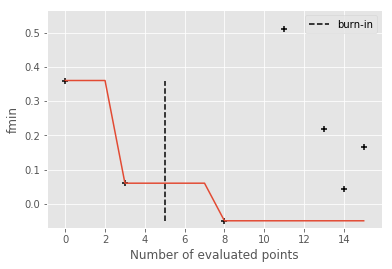

array([[1.        , 0.22399392]])

In [6]:
import gpflowopt as gpo                                                                                                                                                            
from gpflowopt.domain import ContinuousParameter, UnitCube                                                                                                                         
import gpflow as gp                                                                                                                                                                
from gpflowopt.design import LatinHyperCube                                                                                                                                        
from gpflowopt.acquisition import ExpectedImprovement  
from bayes_tec.bayes_opt.mgf import MomentGeneratingFunctionImprovement
from gpflowopt import optim, BayesianOptimizer                                                                                                                                     
import h5py                                                                                                                                                                        
import numpy as np                                                                                                                                                                 
import os                                                                                                                                                                          
from bayes_tec.logging import logging     
from bayes_tec.utils.stat_utils import log_normal_solve
import pylab as plt
plt.style.use('ggplot')
                                                                                                                                                                                   
class BayesHPOpt(object):                                                                                                                                                          
    def __init__(self, objectivefx, fit_params = {}, folds=3, n_jobs=1, init = None):                                                                                              
        self.folds = 3                                                                                                                                                             
        self.n_jobs = 1                                                                                                                                                            
        self._objectivefx = objectivefx                                                                                                                                            
        self.domain = []                                                                                                                                                           
        self.domain_type = []                                                                                                                                                      
        self.fit_params = fit_params                                                                                                                                               
        if init is not None:                                                                                                                                                       
            with h5py.File(init) as f:                                                                                                                                             
                self.init_X = list(f['X'][...])                                                                                                                                    
                self.init_Y = list(f['Y'][...])                                                                                                                                    
                assert len(self.init_X)==len(self.init_Y)                                                                                                                          
        else:                                                                                                                                                                      
            self.init_X = []                                                                                                                                                       
            self.init_Y = []                                                                                                                                                       
        assert callable(objectivefx)                                                                                                                                               
                                                                                                                                                                                   
    def save(self, save_path, clobber=False):                                                                                                                                      
        """Save to hdf5 file"""                                                                                                                                                    
        if os.path.isfile(save_path) and not clobber:                                                                                                                              
            raise ValueError("{} exists already and not clobber".format(save_path))                                                                                                
                                                                                                                                                                                   
        with h5py.File(save_path, 'w') as f:                                                                                                                                       
            f['X'] = np.stack(self.X, axis=0)# N, D                                                                                                                                
            f['Y'] = np.stack(self.Y, axis=0)# N, 1                                                                                                                                
                                                                                                                                                                                   
    def add_continuous_param(self, name, vmin, vmax, log=False):                                                                                                                   
        """                                                                                                                                                                        
        Add a parameter type for optimization.
        name : str keyword name
        vmin : float lower end of range
        vmax : float upper end of range
        log : bool, whether to use log space (then vmin > 0)
        """
        if vmin > vmax:
            vmax_ = vmin
            vmin = vmax
            vmax = vmax_

        if log:
            assert vmin > 0.
            vmin =  np.log(vmin)
            vmax = np.log(vmax)
            self.domain_type.append('log')
        else:
            self.domain_type.append('linear')

        self.domain.append(ContinuousParameter(name,vmin,vmax))

    def add_integer_param(self, name, vmin, vmax):
        ### TODO replace with nunitcube and parametrized bit sampling
        self.domain_type.append("int")
        self.domain.append(ContinuousParameter(name, int(vmin), int(vmax)))

    def add_binary_param(self, name):
        self.domain_type.append('bin')
        self.domain.append(ContinuousParameter(name,0,1))

    def _objective(self,**kwargs):
        y = self._objectivefx(**kwargs)
        return y

    def objective(self, params):
        logging.warning("=== Starting iteration {} ===".format(self.iter))
        params = params.flatten()
        args = {}
        for c,p,t in zip(self.domain, params, self.domain_type):
            if t == 'log':
                args[c.label] = np.exp(p)
            elif t == 'bin':
                args[c.label] = 1. if np.random.uniform() < p else 0.
            elif t == 'int':
                args[c.label] = int(p)
            else:
                args[c.label] = p
        self.X.append(params)
        y = self._objective(**args) # scalar
        self.Y.append(np.array([y]))
        self.save(self.save_path, True)
        logging.warning("=== Result {} ===".format(self.iter))
        logging.warning("{} : {}".format(args, y))
        self.iter += 1
        return np.array([[y]]) # 1, 1
    
    def plot_results(self):
        f = self.ei.data[1][:,0]
        plt.plot(np.arange(0, self.ei.data[0].shape[0]), np.minimum.accumulate(f))
        plt.vlines(self.burnin-1,np.min(f), np.max(np.minimum.accumulate(f)),linestyles='--',label='burn-in')
        plt.ylabel('fmin')
        plt.xlabel('Number of evaluated points')
        plt.legend()
        ylim = plt.ylim()
        plt.scatter(np.arange(0, self.ei.data[0].shape[0]), f, marker='+',c='black')
        plt.ylim(ylim[0],np.max(np.minimum.accumulate(f)) + 0.5*(np.max(np.minimum.accumulate(f)) - np.min(f)))
        plt.show()

    def run(self, save_path, init_design_size=1, n_iter=24, plot=False, likelihood_uncert=1.):
        self.save_path = save_path
        self.iter = 0
        
        self.X = [] + self.init_X
        self.Y = [] + self.init_Y
        
        domain = np.sum(self.domain)
        if init_design_size > 0:
            design = LatinHyperCube(init_design_size,domain)
            X = list(design.generate())
            Y = [self.objective(x).flatten() for x in X]
            self.Y = self.Y + Y
            self.X = self.X + X
        
        
        self.X, self.Y = np.stack(self.X,axis=0), np.stack(self.Y,axis=0)
        
        u = np.concatenate([self.X,self.Y],axis=1)
        u, idx = np.unique(u,return_index=True,axis=0)
        self.X = list(self.X[idx,:])
        self.Y = list(self.Y[idx,:])
        
        self.burnin = len(self.X)
        
        logging.warning("Beginnig search")
#         logging.warning("Initial solutions\n{}".format(list(zip(self.X, self.Y))))
        with gp.defer_build():
            kern = gp.kernels.Matern52(domain.size, ARD=True)# + gp.kernels.White(domain.size)
            m = gp.models.GPR(np.stack(self.X,axis=0), np.stack(self.Y,axis=0), kern)
            lik_var = log_normal_solve(likelihood_uncert**2, 0.5*likelihood_uncert**2)
            m.likelihood.variance = np.exp(lik_var[0])
            m.likelihood.variance.prior = gp.priors.LogNormal(lik_var[0], lik_var[1]**2)
            m.compile()
        self.ei = MomentGeneratingFunctionImprovement(m,0.5)
        opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])
        optimizer = BayesianOptimizer(domain, self.ei, optimizer=opt, hyper_draws=1)

        with optimizer.silent():
            result = optimizer.optimize(self.objective, n_iter=n_iter)
            logging.warning(result)
            if plot:
                self.plot_results()
            return result.x
        
    
def fx(a,b):
    return (a - b + 1)**2 - b*0.1

bo = BayesHPOpt(fx,init=None)
bo.add_binary_param('b')
bo.add_continuous_param('a',-2,2)
bo.run('test_save.hdf5', init_design_size=6, n_iter=10, plot=True, likelihood_uncert=0.01)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.471996
  Number of iterations: 25
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.471996
  Number of iterations: 25
  Number of functions evaluations: 29


Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:
Use the retry module or similar alternatives.


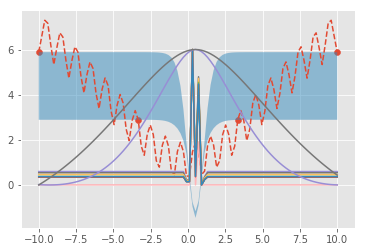

In [2]:
import pylab as plt
import numpy as np
plt.style.use('ggplot')
import gpflowopt as gpo                                                                                                                                                            
from gpflowopt.domain import ContinuousParameter, UnitCube                                                                                                                         
import gpflow as gp                                                                                                                                                                
from gpflowopt.design import LatinHyperCube,RandomDesign                                                                                                                                        
from gpflowopt.acquisition import ExpectedImprovement  
from bayes_tec.bayes_opt.mgf import MomentGeneratingFunctionImprovement
from gpflowopt import optim, BayesianOptimizer                                                                                                                                     
import h5py                                                                                                                                                                        
import numpy as np                                                                                                                                                                 
import os                                                                                                                                                                          
from bayes_tec.logging import logging     
from bayes_tec.utils.stat_utils import log_normal_solve


def ackley_1d(x,y=5.):
        return np.atleast_2d(np.reshape(-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.exp(1) + 20., (-1,))).T - 10.

x_array = np.linspace(-10,10,100)

domain = ContinuousParameter('x',-10,10)

#design = LatinHyperCube(2,domain)
design = LatinHyperCube(4,domain)
X = design.generate()
# X = np.array([[5.],[-3.]])
Y = np.array([ackley_1d(x).flatten() for x in X])


with gp.defer_build():
    kern = gp.kernels.Matern52(domain.size, ARD=True)# + gp.kernels.White(domain.size)
    m = gp.models.GPR(np.stack(X,axis=0), np.stack(Y,axis=0), kern)
    m.mean_function = gp.mean_functions.Constant(5.)
    lik_var = log_normal_solve(0.1**2, 0.5*0.1**2)
    m.likelihood.variance = np.exp(lik_var[0])
    m.likelihood.variance.prior = gp.priors.LogNormal(lik_var[0], lik_var[1]**2)
    m.compile()
    
gp.train.ScipyOptimizer().minimize(m)
    
ei = MomentGeneratingFunctionImprovement(m,1.)
t_array = np.linspace(0,3,10)
eis = [MomentGeneratingFunctionImprovement(m,t) for t in t_array]

opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])
optimizer = BayesianOptimizer(domain, ei, optimizer=opt, hyper_draws=1)

ystar, varstar = m.predict_f(x_array[:,None])

aq = [e.evaluate(x_array[:,None]) for e in eis]
plt.plot(x_array, ackley_1d(x_array),ls='--')
plt.scatter(X[:,0],Y[:,0])
plt.fill_between(x_array, ystar[:,0] - np.sqrt(varstar[:,0]), ystar[:,0] + np.sqrt(varstar[:,0]),alpha=0.5)
[plt.plot(x_array, 6*(a[:,0]-np.min(a))/np.max(a[:,0]-np.min(a)), label=t) for a,t in zip(aq,t_array)]
plt.show()










#  ging.warning(result)

# logging.warning("Beginnig search")
# #         logging.warning("Initial solutions\n{}".format(list(zip(self.X, self.Y))))
# 
# self.ei = MomentGeneratingFunctionImprovement(m,0.5)
# opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])
# optimizer = BayesianOptimizer(domain, self.ei, optimizer=opt, hyper_draws=1)

# with optimizer.silent():
#     result = optimizer.optimize(self.objective, n_iter=n_iter)
#     logging.warning(result)
#     if plot:
#         self.plot_results()
#     return result.x



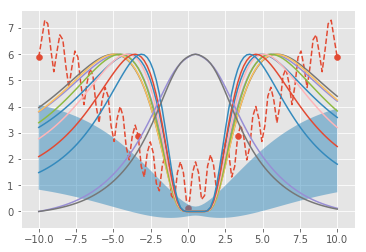

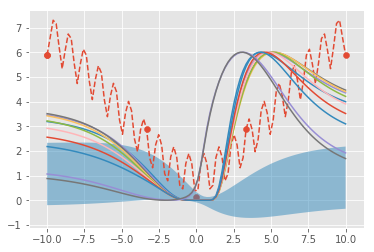

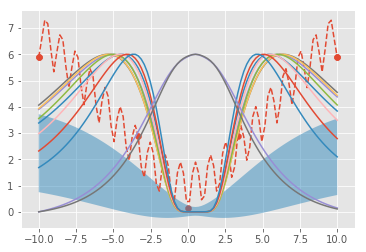

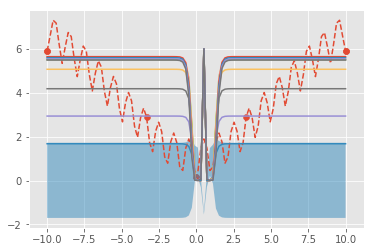

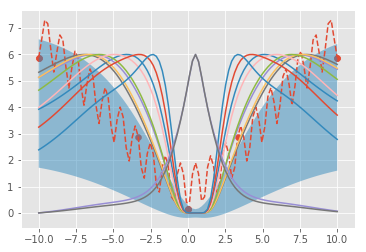

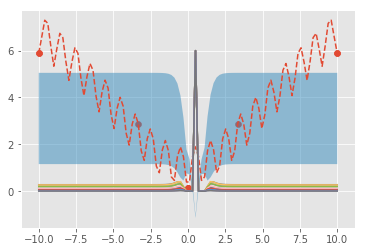

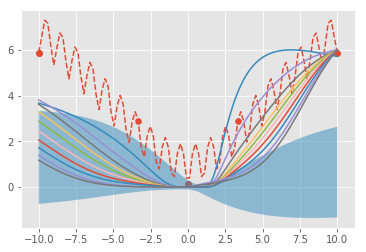

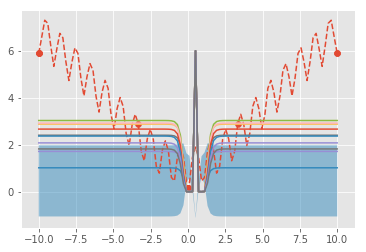

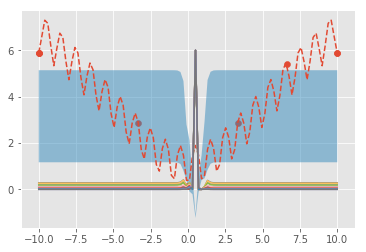

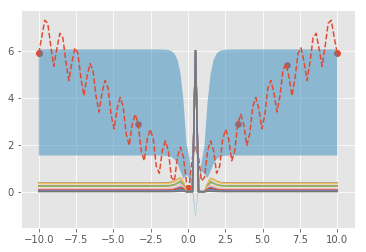

In [3]:
for i in range(10):
    result = optimizer.optimize(ackley_1d, n_iter=1)
    ystar, varstar = m.predict_f(x_array[:,None])
    X,Y = ei.data
    aq = [e.evaluate(x_array[:,None]) for e in eis]
    plt.plot(x_array, ackley_1d(x_array),ls='--')
    plt.scatter(X[:,0],Y[:,0])
    plt.fill_between(x_array, ystar[:,0] - np.sqrt(varstar[:,0]), ystar[:,0] + np.sqrt(varstar[:,0]),alpha=0.5)
    [plt.plot(x_array, 6*(a[:,0]-np.min(a))/np.max(a[:,0]-np.min(a)), label=t) for a,t in zip(aq,t_array)]
    plt.show()

In [ ]:
ei.data